In [3]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
from astropy.io import ascii
from itertools import cycle
import math

import matplotlib.gridspec as gridspec

%matplotlib inline

# Plotting code

In [4]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """
    
    zidx = []
    uniqueMappableList = np.unique(mappableList)
    for j in range(len(mappableList)):
        for i,entry in enumerate(uniqueMappableList):
            if mappableList[j] == entry:
                zidx.append(i)
    
    zidx = np.array((zidx))
    uniqueVals = len(np.unique(zidx))
    
    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= uniqueVals: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,uniqueVals):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [3]:
def makePlot(ax, xdata, ydata, colours, xlabel, ylabel, sizes=100,
             legendTitle=None,legendEntries=None, legendColours=None,
             xlim=[], ylim=[],xscale="linear",yscale="linear",alpha=1):
    ax.scatter(xdata,ydata,c=colours,s=sizes,alpha=alpha)
    #ax.hexbin(xdata,ydata,cmap='Blues')
    nonans = (np.isfinite(xdata) & np.isfinite(ydata))
    xdata=xdata[nonans]
    ydata=ydata[nonans]
    colours=colours[nonans]
    
    xmin = np.min(xdata[xdata > 0.])#.value
    xmax = np.max(xdata)#.value
    
    ymin = np.min(ydata[ydata > 0.])#.value
    ymax = np.max(ydata)#.value

    if not xlim:
        if xscale=="log":
            ax.set_xlim(0.1*xmin,10.*xmax)
        else:
            ax.set_xlim(0.95*xmin,1.05*xmax)
    else:
        ax.set_xlim(xlim)
        
    if not ylim:
        if yscale=="log":
            ax.set_ylim(0.1*ymin,10.*ymax)
        else:
            ax.set_ylim(0.95*ymin,1.05*ymax)
    else:
        ax.set_ylim(ylim)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    ax.set_xlabel(xlabel,fontsize=24)
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(labelsize=18)
    
    if legendEntries is not None:
        if xscale=="log":
            minx = 1.e-7*xmin
        else:
            minx = -1000+(-1000*xmin)
                
        if yscale=="log":
            miny = 1.e-7*ymin
        else:
            miny = -1000+(-1000*ymin)
            
        for i in range(0,len(legendEntries)):
            ax.scatter([minx,minx],[miny,miny],s=200,c=legendColours[i],edgecolors=legendColours[i],label='{0}'.format(legendEntries[i]))
        leg=ax.legend(loc=0,ncol=1,frameon=False,fontsize=15,title=legendTitle)
        leg.get_title().set_fontsize('22')
    return 

# Planet data in usable format
## each planet object includes some combination of: [Teff, logg, [Fe/H], Rp/R*, P]

In [136]:
experimentClass = "oneGrammar_overlappingRp"
experimentName = "Rp_uniformP"
n_planet_features = 2
n_stellar_features = 0
n_features = n_planet_features + n_stellar_features

-2.07020723759
2.98667771528


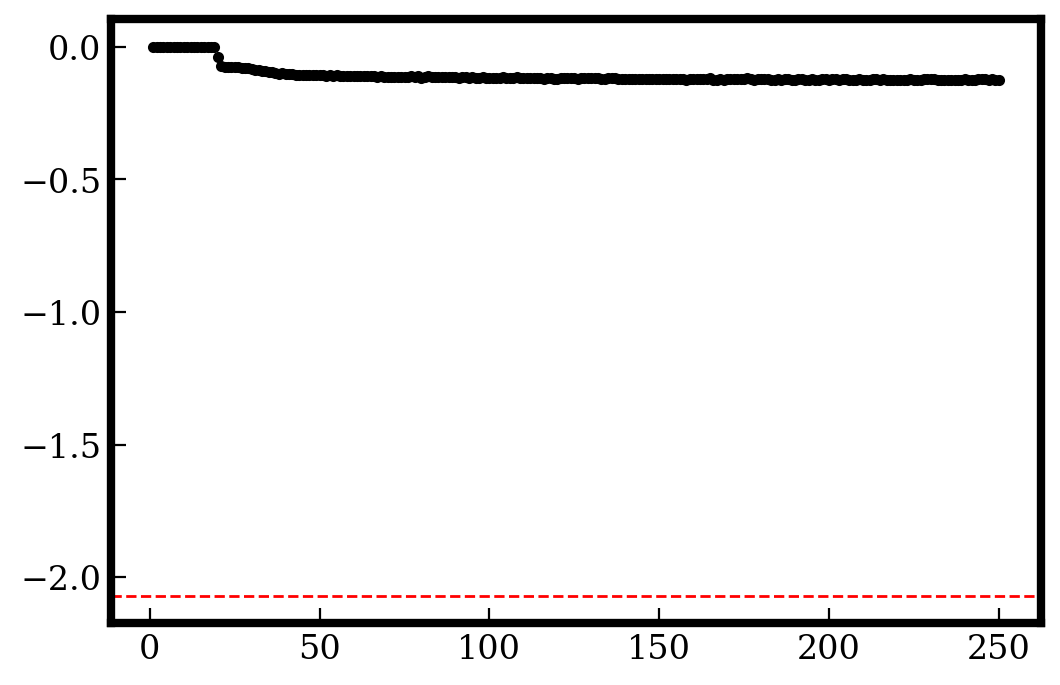

In [137]:
results = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_classprobs.npy".format(experimentClass,experimentName))
idxs = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_idxs.npy".format(experimentClass,experimentName))
losses = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_losses.npy".format(experimentClass,experimentName))

optimalLoss = float(np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_optimalLoss.npy".format(experimentClass,experimentName)))
print(optimalLoss)
bits = -1*optimalLoss*math.log(math.e,2)
print(bits)
plt.plot(losses[:,0],losses[:,1],'k.')
plt.axhline(y=optimalLoss,color='r',ls="--",lw=1)
plt.show()

[[6.20639217e-12 9.99997616e-01 2.40789063e-06]
 [3.39747726e-06 9.98182416e-01 1.81420462e-03]
 [5.60665976e-05 1.57918781e-04 9.99786079e-01]
 ...
 [9.99999762e-01 1.00232956e-11 2.50990581e-07]
 [1.00000000e+00 4.29057551e-15 3.55447782e-10]
 [9.21947917e-20 1.00000000e+00 2.85956453e-10]]
[[6.20639217e-12 9.99997616e-01 2.40789063e-06]
 [3.39747726e-06 9.98182416e-01 1.81420462e-03]
 [5.60665976e-05 1.57918781e-04 9.99786079e-01]
 ...
 [9.99999762e-01 1.00232956e-11 2.50990581e-07]
 [1.00000000e+00 4.29057551e-15 3.55447782e-10]
 [9.21947917e-20 1.00000000e+00 2.85956453e-10]]


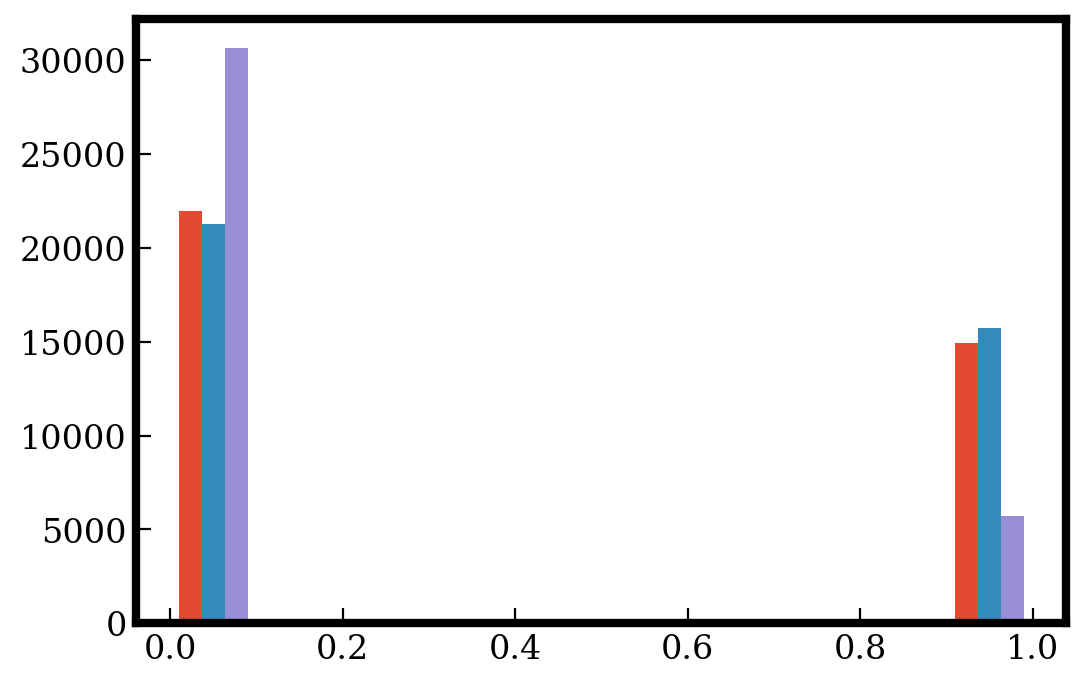

In [138]:
print(results)
print(results)

plt.hist(results)
plt.show()

(37539, 2)
[1 1 2 ... 0 0 1]
(37539,)
(37539,)
[1. 0. 1. ... 0. 0. 1.]


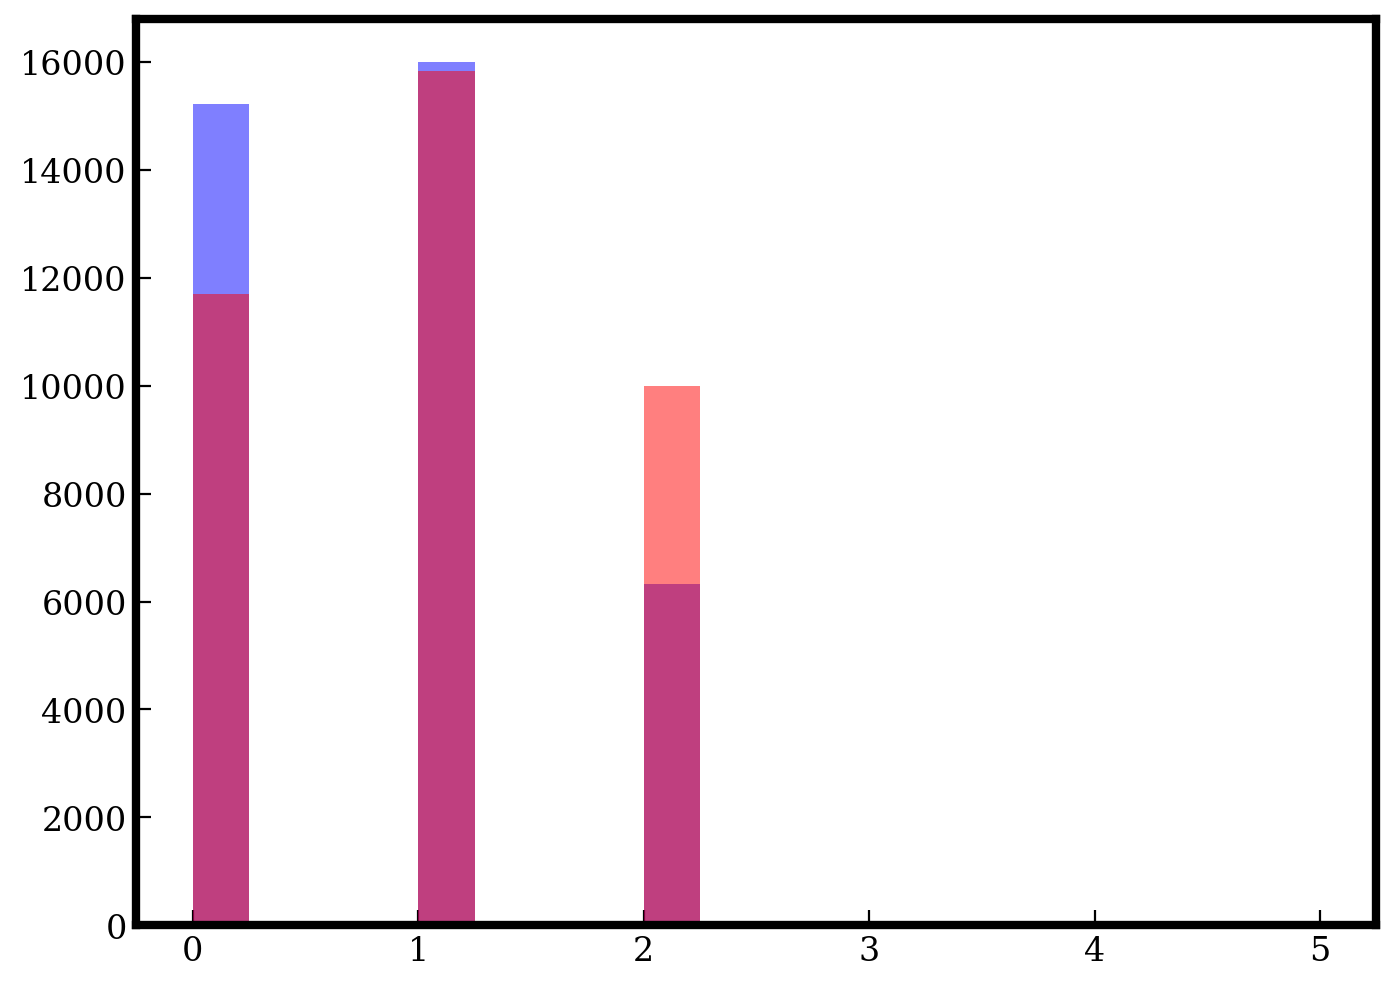

In [139]:
with open("simulatedPlanets/{0}/fake_grammaticalSystems_{1}.txt".format(experimentClass,experimentName), "rb") as picklefile:
    systems = pickle.load(picklefile)

data = np.zeros((1,n_features))

for i in range(len(systems)):
    sys = systems[i]
    for j in range(len(sys)):
        data = np.vstack((data,np.array(sys[j])))
        
data = data[1:][idxs]
print(np.shape(data))

bestClass = np.argmax(results,axis=1)
print(bestClass)
print(np.shape(bestClass))


trueClass = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_truths.npy".format(experimentClass,experimentName))
trueClass = trueClass[idxs]
print(np.shape(trueClass))
print(trueClass)

#note ---the bars don't line up in this histogram because the class labels are out of order!
fig = plt.figure(figsize=(8,6))
plt.hist(bestClass,bins=20,range=(0,5),color='b',alpha=0.5)
plt.hist(trueClass,bins=20,range=(0,5),color='r',alpha=0.5)
plt.show()

In [140]:
print(np.min(data[:,-1]))
print(np.max(data[:,-1]))

-1.736980138625431
1.7311459795629556


In [141]:
#labels = [r'$R_p\ [R_\odot]$']
#scaledLimits = [(-3.5,2.5)]

#labels = [r'$R_p/R_*$',r'P']
#scaledLimits = [(-2,2.5),(-0.1,4.)]

labels = [r'$R_p\ [R_\odot]$',r'P [days]']
#scaledLimits = [(-3.5,2.5),(-1.,5.)]
scaledLimits = [(-1.5,4),(-2.,2.)]

#labels = [r'$R_p\ [R_\odot]$',r'$T_{eff}$ [K]']
#scaledLimits = [(-3.5,2.5),(-4,5.5)]

#labels = [r'$R_p\ [R_\odot]$',r'P [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]',r'[Fe/H]',]
#limits = [(3000,8000),(3.0,5.5),(-1.25,0.6),(0.0,0.3),(0,600)]
#scaledLimits = [(-2,2.5),(-1.,4.5),(-4.,5.5),(-4.5,3),(-4,3.5)]


In [142]:
#unscaledData = copy.deepcopy(data)
#unscaledData[:,0] = (unscaledData[:,0]*3.41531066e-02)+5.08794529e-02 #unscale Rp
#unscaledData[:,1] = (unscaledData[:,1]*1.44231050e+02)+2.49761201e+02 #unscale P
#print(np.shape(unscaledData))
#print(np.min(unscaledData[:,0]))
#print(np.max(unscaledData[:,0]))
#print(np.min(unscaledData[:,1]))
#print(np.max(unscaledData[:,1]))

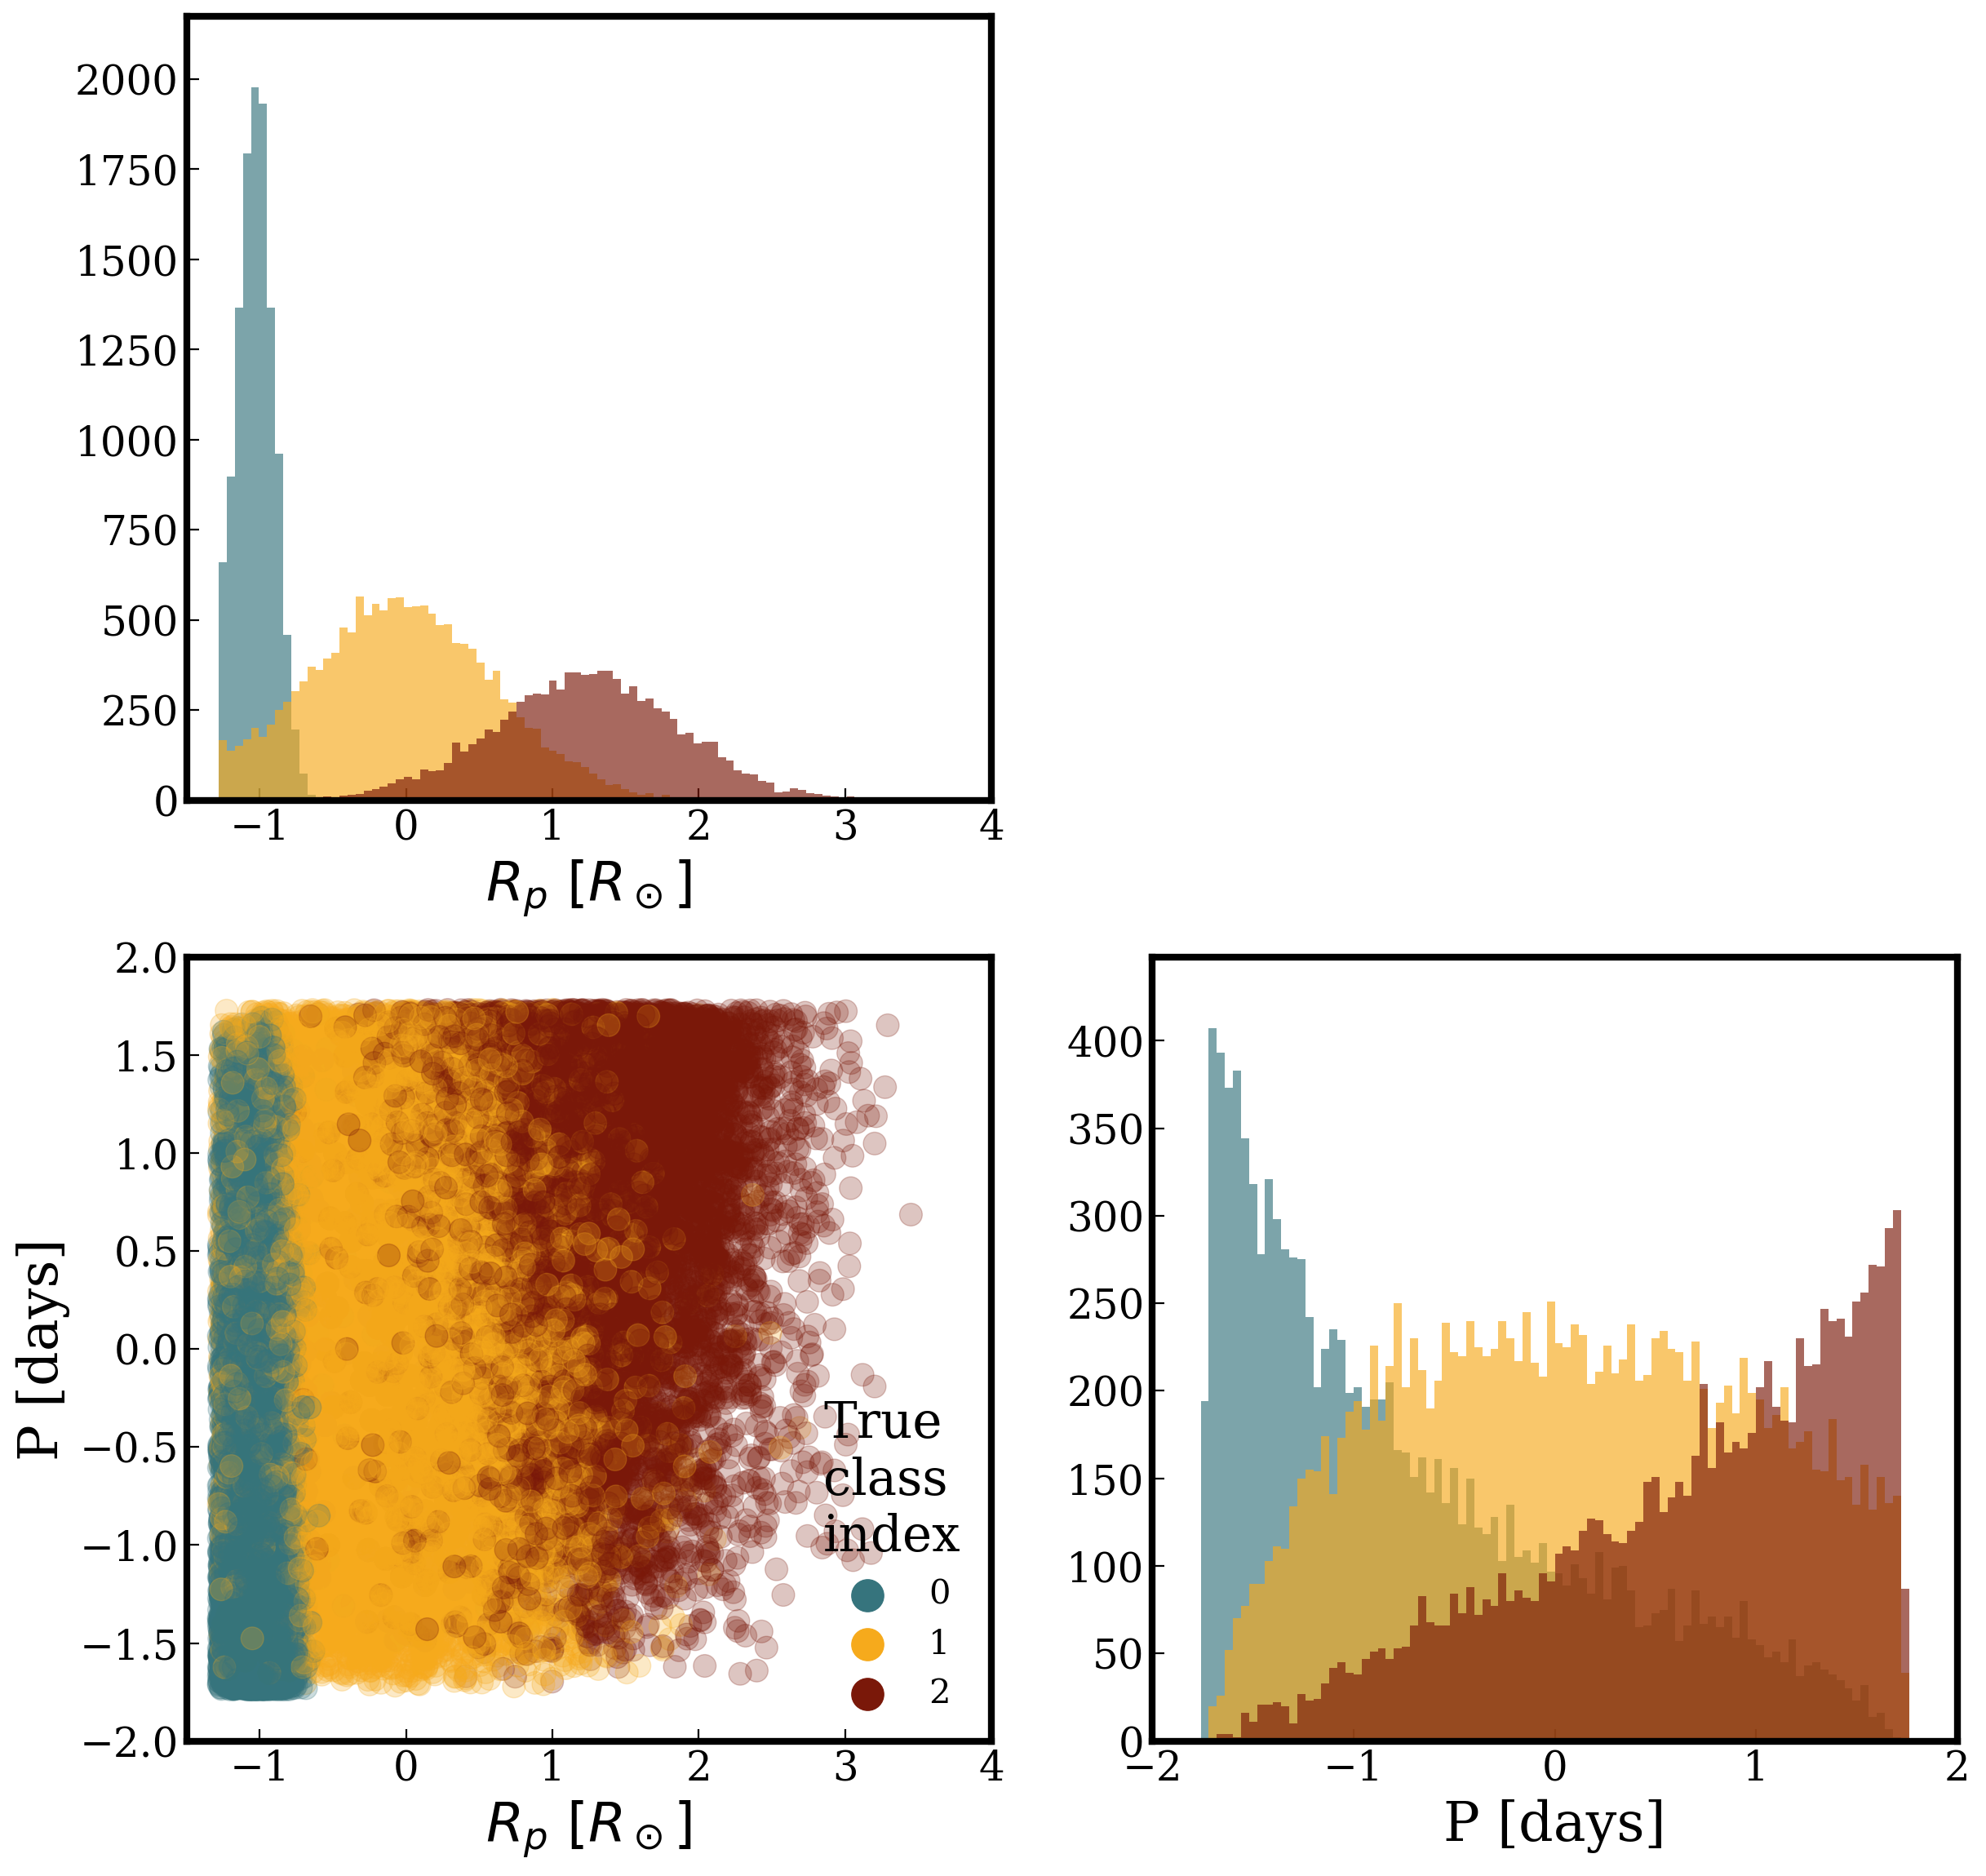

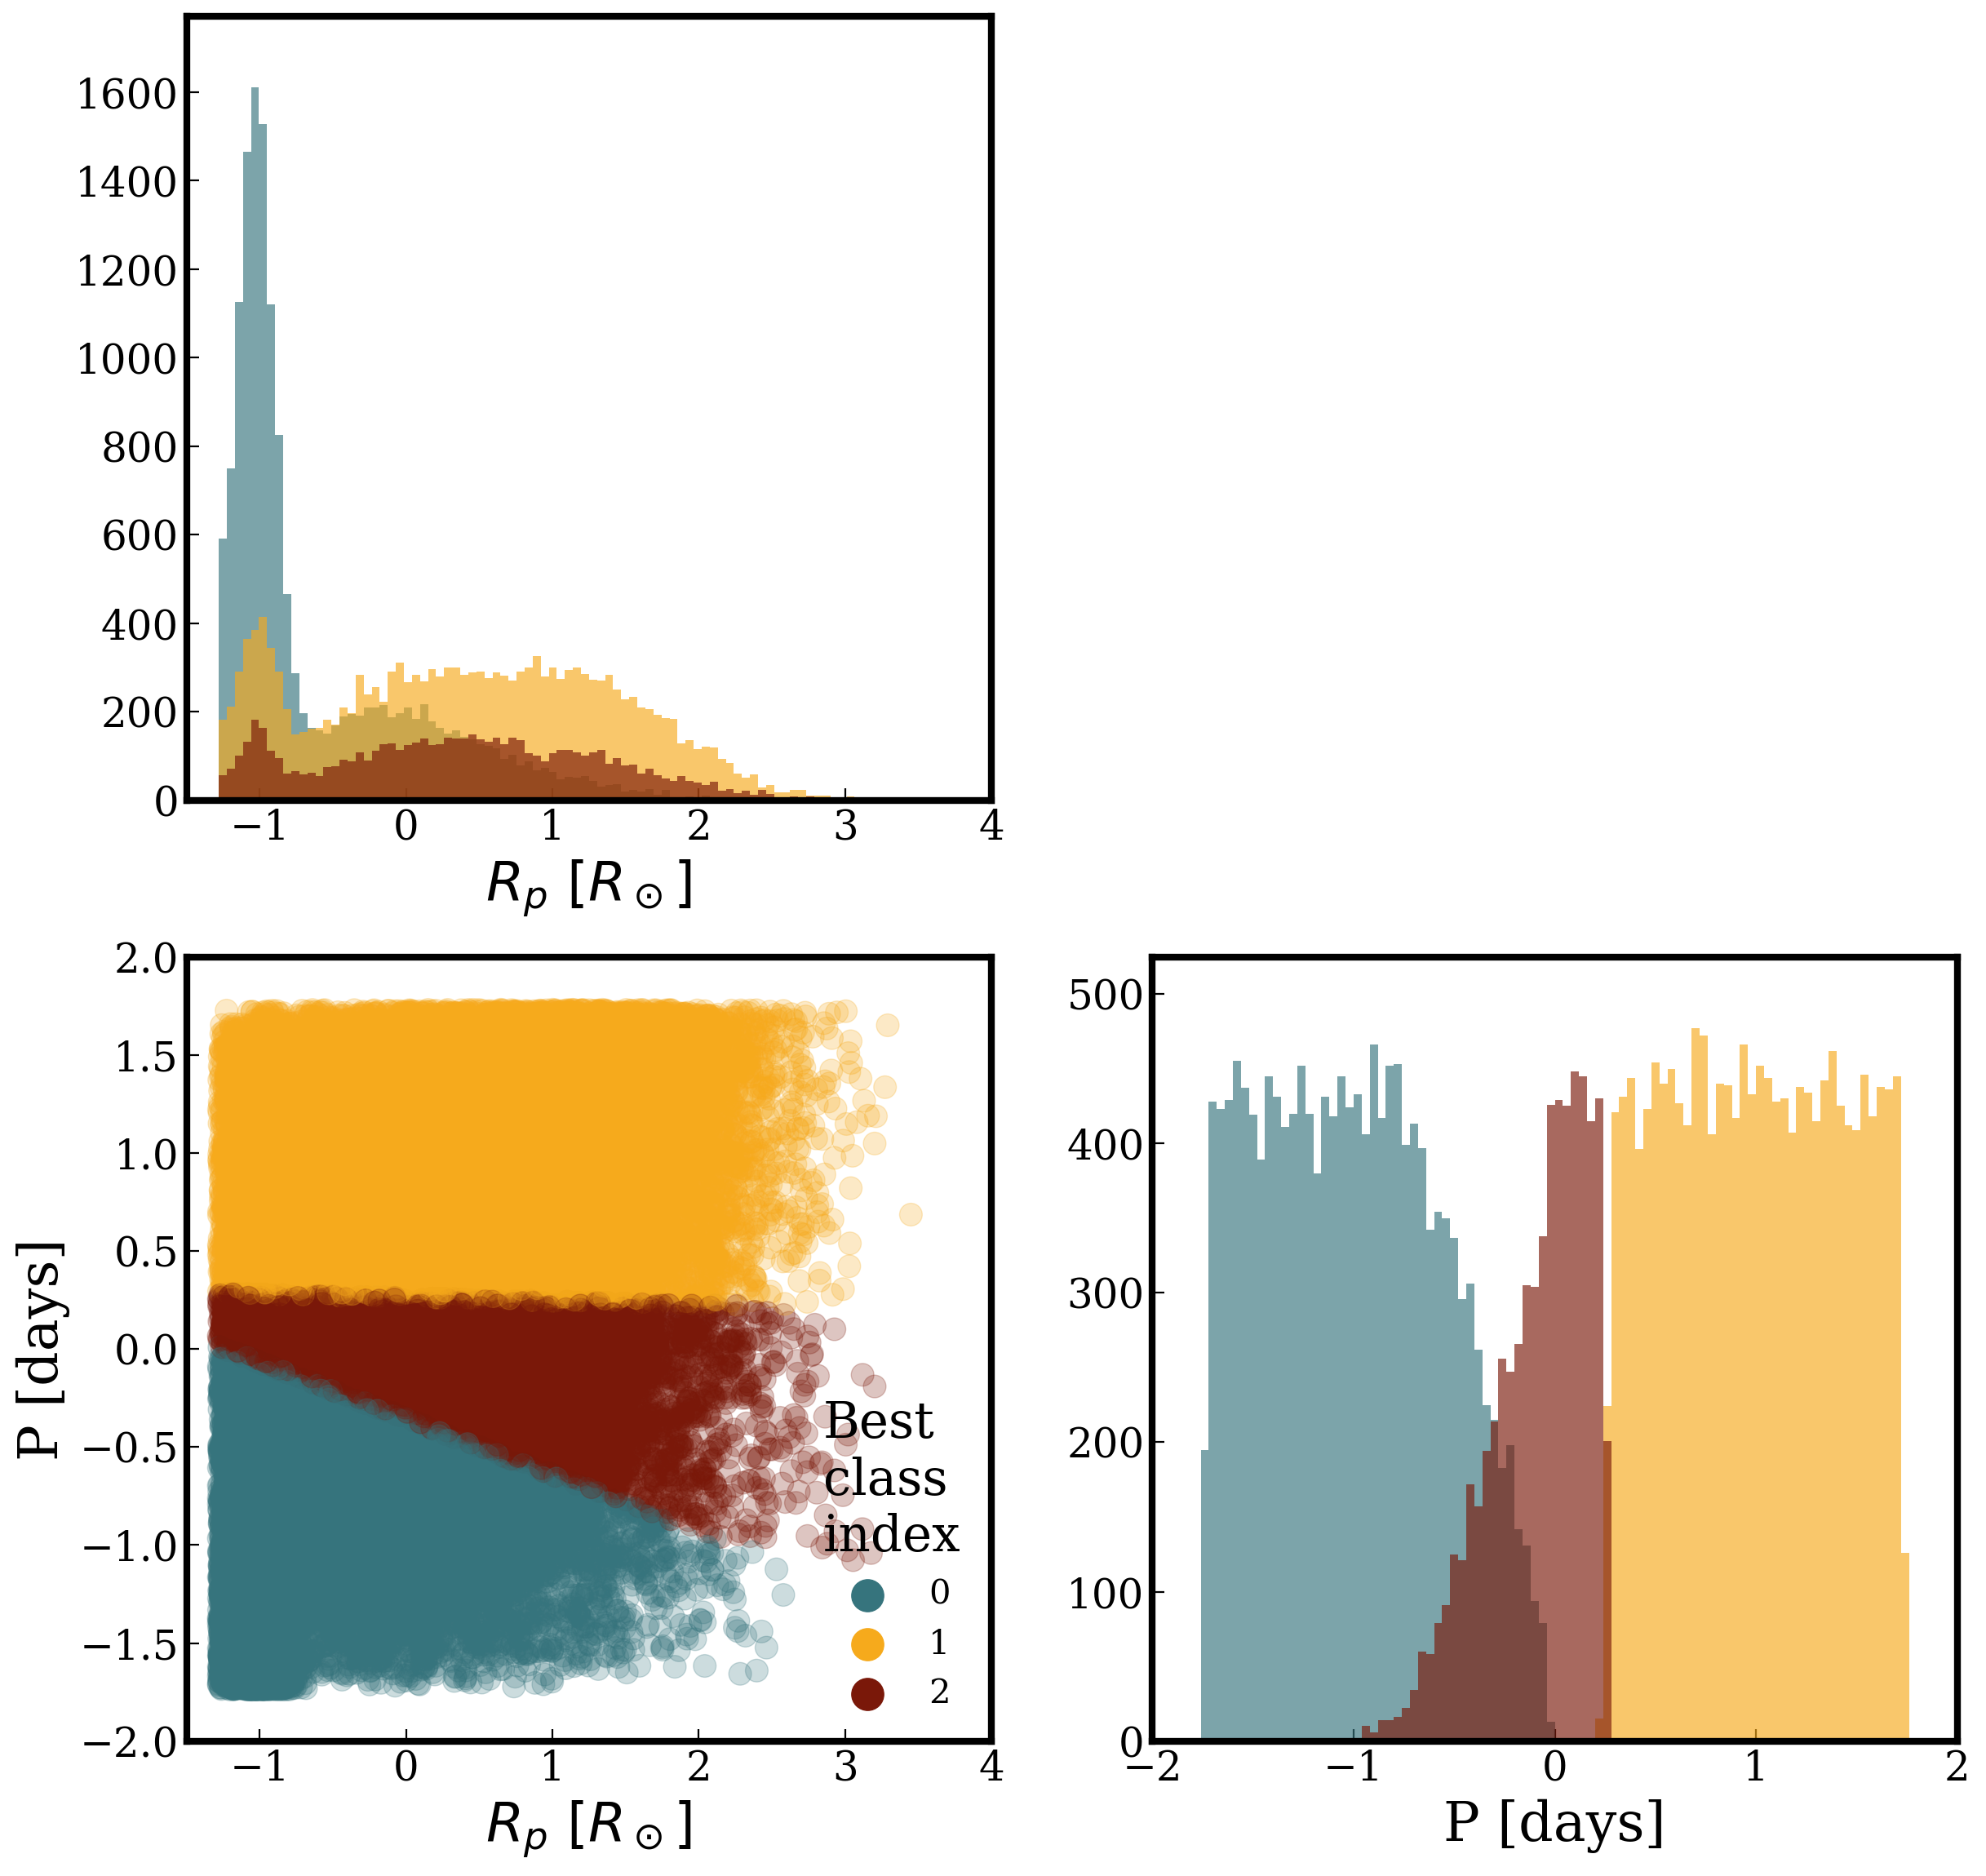

In [143]:
classColoursList = ['#36747D','#F6AA1C','#7A1809','#003049','#BF3E0B','#2E8B57','#EE4266','#540D6E']
#cl = ['#7A1809','#36747D','#F6AA1C']

# TRUTHS and RESULTS
arrays_ = [trueClass, bestClass]
titles_ = ["True","Best"]
plotTitles_ = ["truths","results"]

for h in range(0,2):
    class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)
    #print(data[:,0][0:10])
    #print(data[:,1][0:10])
    #print(class_colours[0:10])
    fig = plt.figure(figsize=(7*n_features,7*n_features))
    gs = gridspec.GridSpec(n_features, n_features)

    for i in range(n_features):
        for j in range(n_features):
            if i>j:
                ax = plt.subplot(gs[i,j])
                makePlot(ax,
                        xdata=data[:,j],#+arrays_[h]/3.,
                        ydata=data[:,i],
                        colours=class_colours,
                        xlim=scaledLimits[j],
                        ylim=scaledLimits[i],
                        legendTitle="{0}\nclass\nindex".format(titles_[h]),
                        legendEntries=np.array(class_legendEntries).astype(int),
                        legendColours=class_legendColours,
                        #xscale="log",
                        #yscale="log",
                        xlabel=labels[j],
                        ylabel=labels[i],
                        alpha=0.25)

            if i==j:
                ax = plt.subplot(gs[i,j])
                toHist = []
                nmax = 0
                for k in np.unique(arrays_[h]).astype(int):
                    #toHist.append(data[:,i][arrays_[h]==k])
                    try:
                        n,bins,patches=ax.hist(data[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                        if np.max(n)>nmax:
                            nmax=np.max(n)
                    except IndexError:
                        n,bins,patches=ax.hist(data[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                        if np.max(n)>nmax:
                            nmax=np.max(n)
                    
                #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                #nmax = np.max(n)
                ax.set_xlabel(labels[i],fontsize=24)
                ax.tick_params(labelsize=18)
                ax.set_xlim(scaledLimits[i])
                ax.set_ylim(0,nmax*1.1)


    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    #plt.show()
    plt.savefig("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_{2}.png".format(experimentClass,experimentName,plotTitles_[h]),fmt="png")

# What are the weights in layer 1 doing?

In [131]:
from matplotlib import cm

In [132]:
# Context rep
ws = np.load("./ContextRep_linear1weights.npy")
bs = np.load("./ContextRep_linear1biases.npy")
nSteps = np.shape(ws)[0]
nInputs = np.shape(bs)[1]
print(np.shape(ws))
print(np.shape(bs))

(945, 160)
(945, 20)


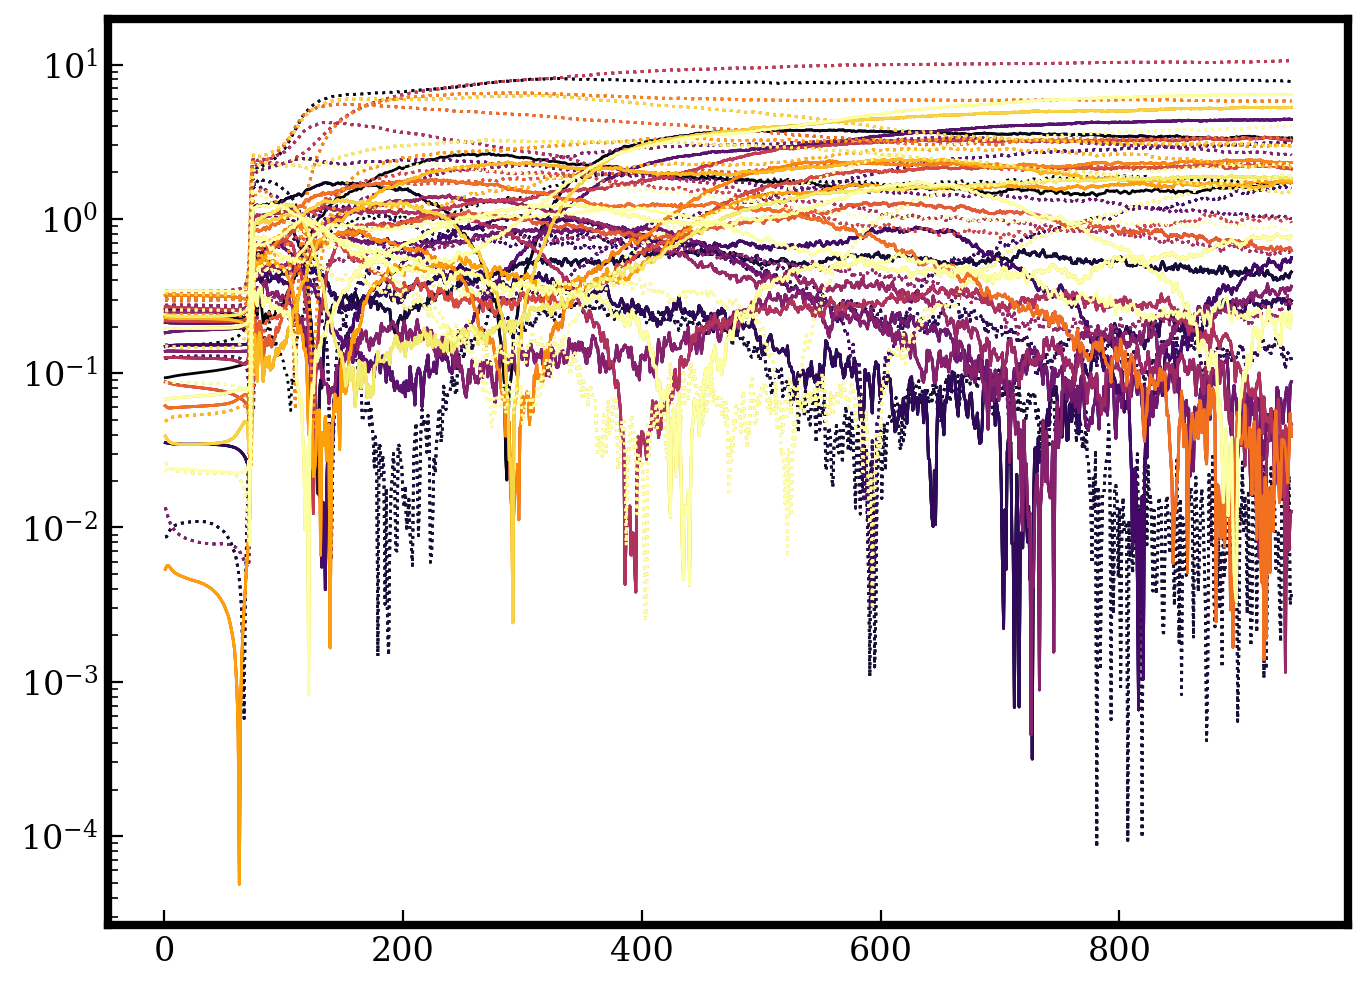

In [133]:
colors = [ cm.inferno(x) for x in np.linspace(0, 1, nInputs) ]

fig = plt.figure(figsize = (8,6))
for i in range(0,nInputs):
    for j in np.arange(0,8,2):
        plt.plot(np.arange(nSteps),np.abs(ws[:,2*i + j]),color = colors[i],ls='-',lw=1) # feature 0 weights
    
    for j in np.arange(1,9,2):
        plt.plot(np.arange(nSteps),np.abs(ws[:,2*i + j]),color = colors[i],ls=':',lw=1) # feature 1 weights
    
    #plt.plot(np.arange(nSteps),np.abs(bs[:,i]),color = colors[i],ls='--',lw=1)         # biases

plt.yscale("log")
#plt.show()
plt.savefig("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_ContextRep_linear1.pdf".format(experimentClass,experimentName),fmt="pdf")

In [134]:
# Planet rep
ws = np.load("./PlanetRep_linear1weights.npy")
bs = np.load("./PlanetRep_linear1biases.npy")
nSteps = np.shape(ws)[0]
nInputs = np.shape(bs)[1]
print(np.shape(ws))
print(np.shape(bs))

print(nSteps)
print(nInputs)

(945, 40)
(945, 20)
945
20


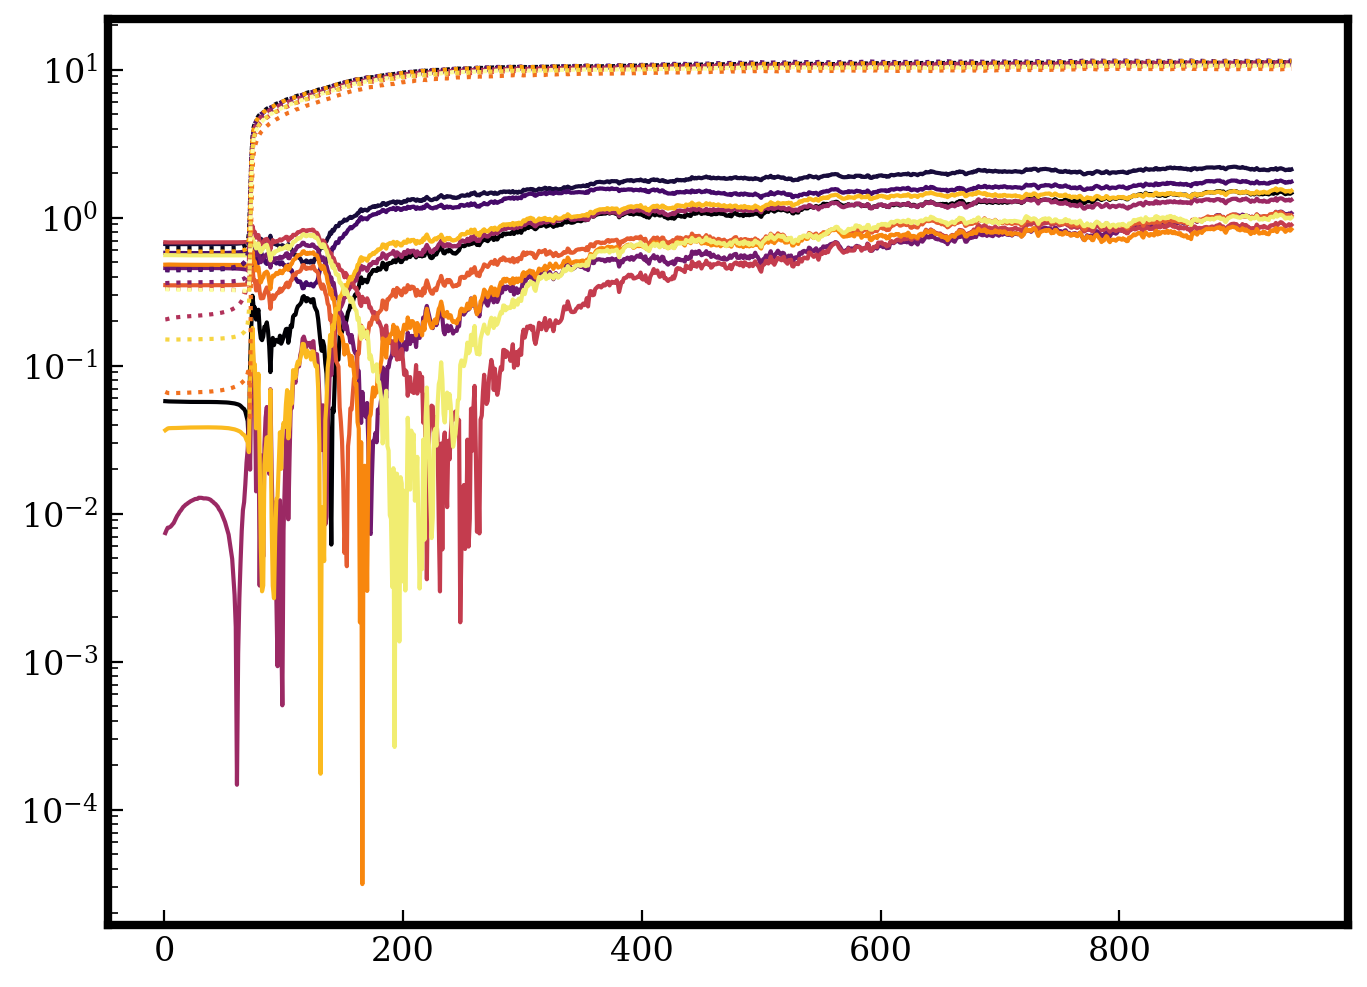

In [135]:
colors = [ cm.inferno(x) for x in np.linspace(0, 1, nInputs) ]

fig = plt.figure(figsize = (8,6))
for i in np.arange(0,nInputs,2):
    plt.plot(np.arange(nSteps),np.abs(ws[:,i]),color = colors[i],ls='-',lw=1.5)     # feature 0 weights
    
for i in np.arange(1,nInputs+1,2):
    plt.plot(np.arange(nSteps),np.abs(ws[:,i]),color = colors[i],ls=':',lw=1.5) # feature 1 weights

#for i in range(0,nInputs):
    #plt.plot(np.arange(nSteps),np.abs(bs[:,i]),color = colors[i],ls='--',lw=1)       # biases
#plt.title("linear 1 weights. - = Rp weight; : = P weight; -- = bias")
plt.yscale("log")
#plt.show()
plt.savefig("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_PlanetRep_linear1.pdf".format(experimentClass,experimentName),fmt="pdf")

# Look at POS tagging results

In [ ]:
posResults = np.load("../POStagger/example.w_classprobs.npy")
print(posResults)
print(np.argmax(posResults,axis=1))
words = ['chased','chased','chased','cat','the','dog','dog','rat','the','the','cat','the','the','the','rat'] # as encoded in Y1
posTruths = ['V', 'V', 'V', 'N', 'D', 'N', 'N', 'N', 'D', 'D', 'N', 'D', 'D', 'D', 'N']
posTruthIdxs = np.array((0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1))
print(posTruthIdxs)

# So everything appears to be working fine, except that the ordering in Y1 is not intuitive, and I should double-check
# that it's right in the planet case.

## What about when I make sentences like: "dog dog dog dog", "chased chased chased", "the the the the the the". Does it work?

In [ ]:
# Yes!! Although something about indexing is a little weird...
posSameResults = np.load("../POStagger/exampleSame.w_classprobs.npy")
posSameIdxs = np.load("../POStagger/exampleSame.w_idxs.npy")
posSameIdxs[posSameIdxs==3] = 0
posSameIdxs[posSameIdxs==2] = 4
posSameIdxs[posSameIdxs==1] = 2
posSameIdxs[posSameIdxs==4] = 1

print(posSameIdxs)
print(np.argmax(posSameResults,axis=1))

In [ ]:
test = np.zeros((1000,3))
print(np.shape(np.mean(test,axis=0)))

In [ ]:
test = np.vstack((np.ones(10),np.zeros(10)))

In [ ]:
print(test.T)
print(np.ravel(test.T))

# Understanding the cost function: 

# J [to be minimized] =  H(q,p) [cross-entropy term] - H(z) [prevents trivial solutions]

In [158]:
def crossEntropy(q, p):
    q[q==0.] = 1.e-15
    p[p==0.] = 1.e-15
    return -np.sum(q*np.log(p))

## One training example. How do the components of J depend on (1) agreement between classifiers q and p and (2) confidence of classifiers q and p?

/Users/Emily/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


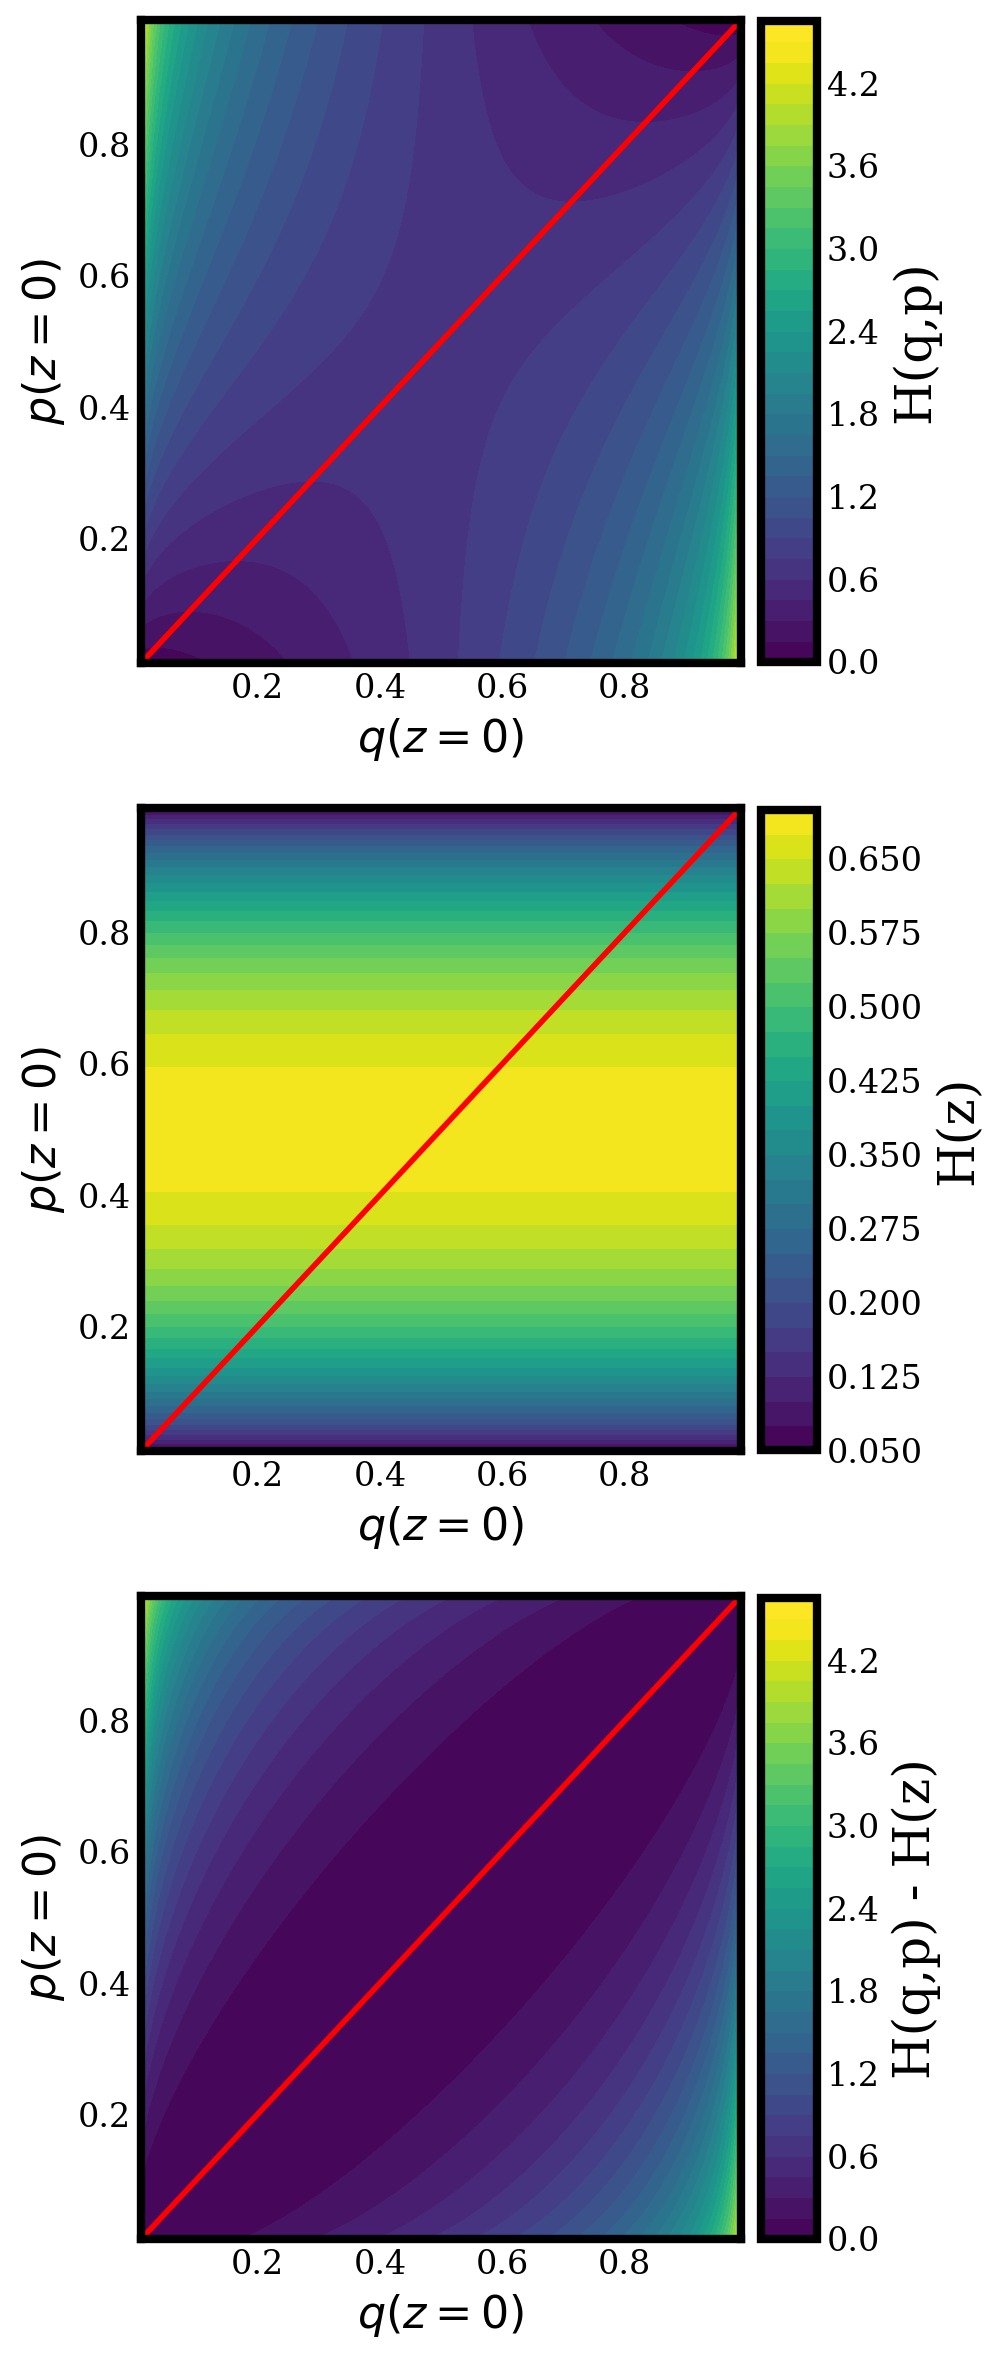

In [130]:
q0 = np.linspace(0.01,0.99,100.)

ces_em = np.zeros((len(q0),len(q0)))
ces_Hz_em = np.zeros((len(q0),len(q0)))

ces_zep = np.zeros((len(q0),len(q0)))
ces_Hz_zep = np.zeros((len(q0),len(q0)))

Hzs = np.zeros((len(q0),len(q0)))

for i in range(len(q0)):
    for j in range(len(q0)):
        qarr = np.array((q0[i],1. - q0[i]))
        parr = np.array((q0[j],1. - q0[j]))
        
        ces_em[i,j] = crossEntropy(qarr,parr)
        ces_zep[i,j] = -q0[i]*np.log(q0[j]) - (1. - q0[i])*np.log(1. - q0[j])
        
        Hzs[i,j] = ( -q0[i]*np.log(q0[i]) - (1.-q0[i])*np.log(1.-q0[i]))
        
        ces_Hz_em[i,j] = crossEntropy(qarr,parr) - ( -q0[i]*np.log(q0[i]) - (1.-q0[i])*np.log(1.-q0[i]))
        ces_Hz_zep[i,j] = -q0[i]*np.log(q0[j]/q0[i]) - (1. - q0[i])*np.log((1.-q0[j])/(1.-q0[i]))
        
fig = plt.figure(figsize=(4,12))
gs = gridspec.GridSpec(3,1)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])
ax2 = fig.add_subplot(gs[2,:])

h0 = ax0.contourf(q0,q0,ces_em,30,vmin=0.,vmax=4.5)
h1 = ax1.contourf(q0,q0,Hzs,30)
h2 = ax2.contourf(q0,q0,ces_Hz_zep,30,vmin=0.,vmax=4.5)

cax0 = fig.add_axes([0.98, 0.7175, 0.07, 0.267])
cax1 = fig.add_axes([0.98, 0.389, 0.07, 0.267])
cax2 = fig.add_axes([0.98, 0.0605, 0.07, 0.267])

cb0 = fig.colorbar(h0, cax=cax0, orientation='vertical')
cb1 = fig.colorbar(h1, cax=cax1, orientation='vertical')
cb2 = fig.colorbar(h2, cax=cax2, orientation='vertical')

cblabels = ['H(q,p)','H(z)','H(q,p) - H(z)']
for i,cb in enumerate([cb0,cb1,cb2]):
    cb.set_label(cblabels[i],fontsize=18)
    
for ax in [ax0,ax1,ax2]:
    ax.plot(q0,q0,'r-',lw=2)
    ax.set_xlabel(r"$q(z=0)$",fontsize=16)
    ax.set_ylabel(r"$p(z=0)$",fontsize=16)
#plt.xlim(-0.1,1.1)
#plt.ylim(-0.1,1.1)
#plt.show()
plt.tight_layout()
plt.savefig("./costFunction_1trainingexample.pdf",fmt="pdf",bbox_inches="tight")

## Many identical training examples. How do the components of J depend on (1) agreement between classifiers q and p and (2) confidence of classifiers q and p?

### Answer: it's the same as above, because of the 1/N weighting on the cross-entropy term .

/Users/Emily/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


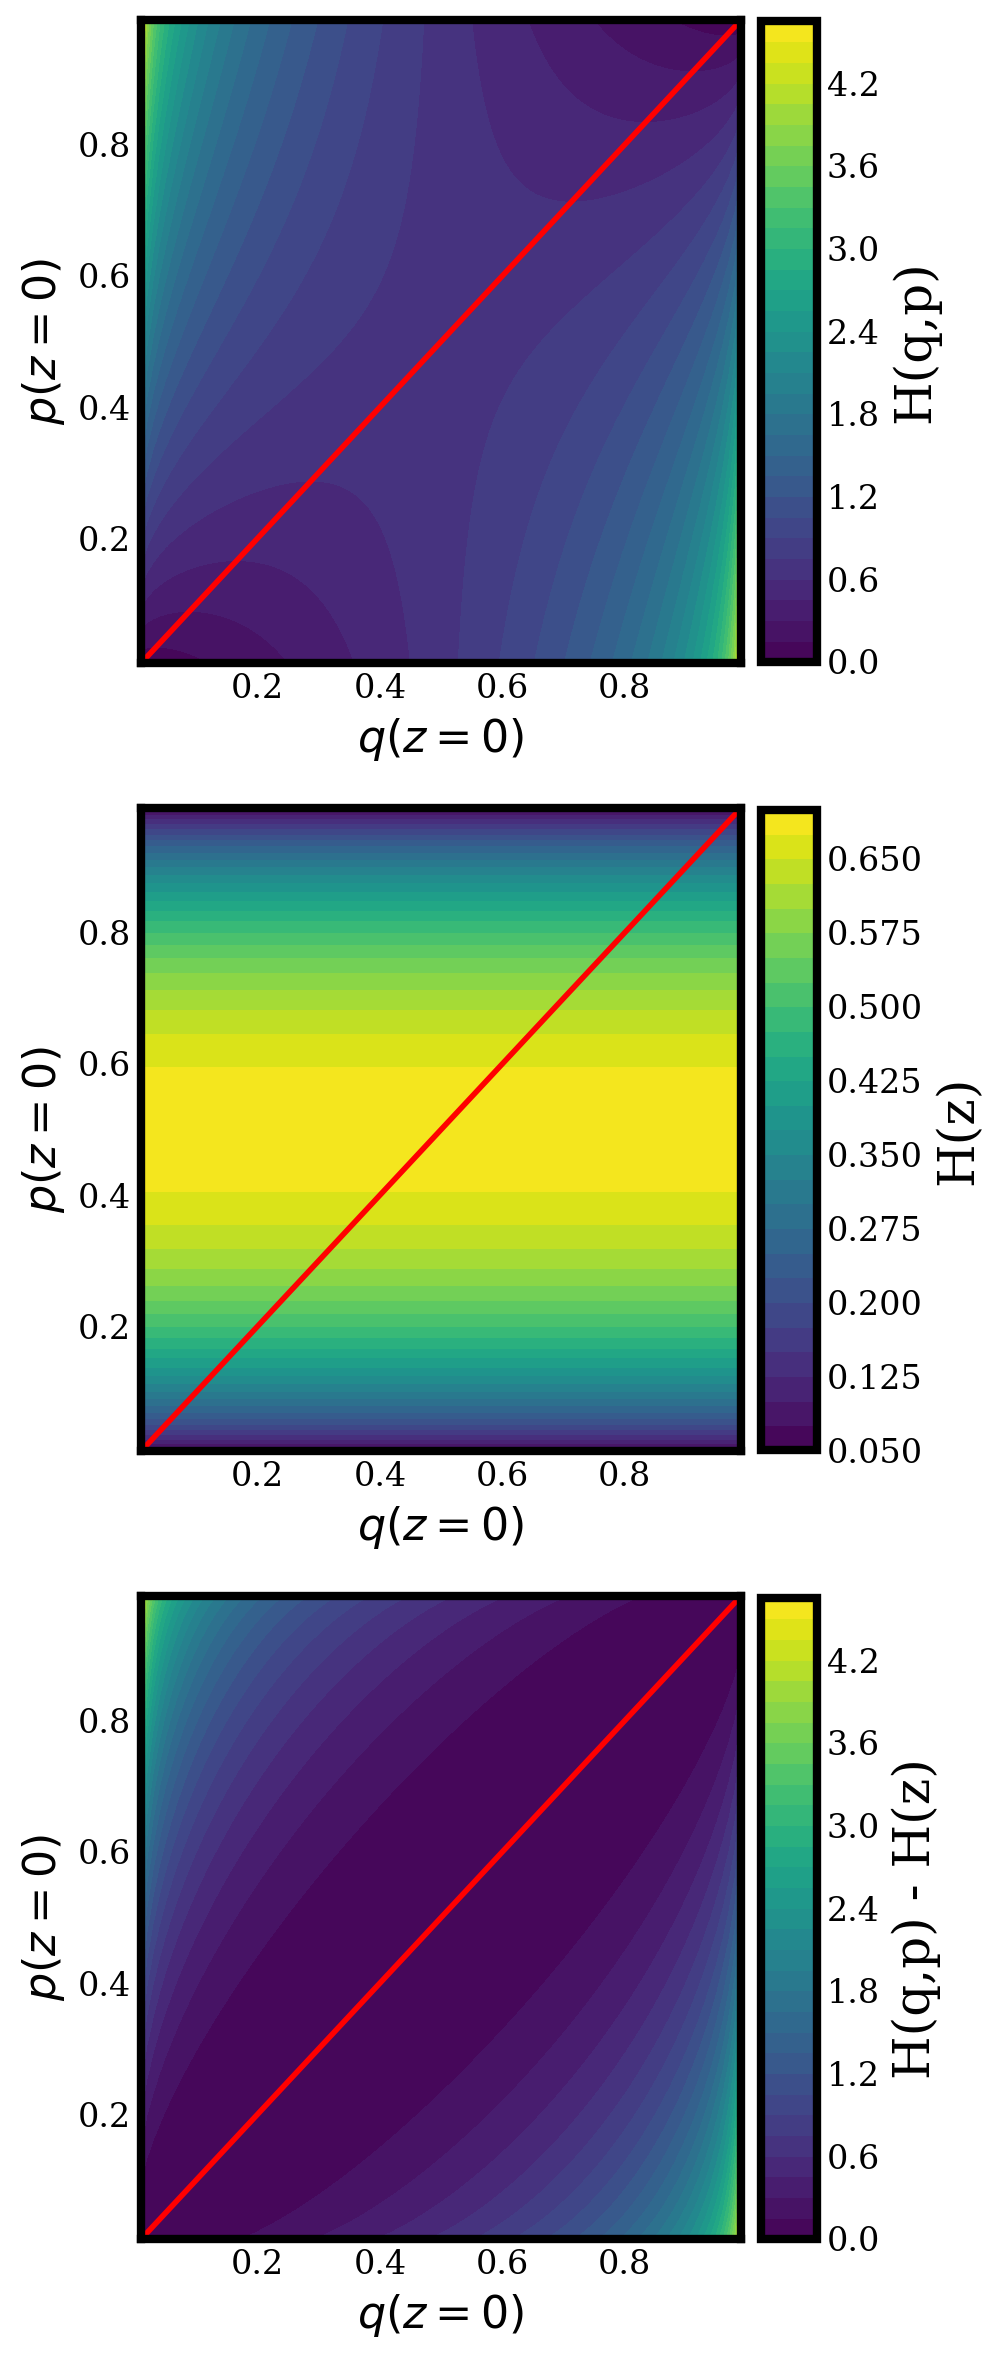

In [134]:
nTraining = 10

q0 = np.linspace(0.01,0.99,100.)

ces_em = np.zeros((len(q0),len(q0)))
ces_Hz_em = np.zeros((len(q0),len(q0)))

Hzs = np.zeros((len(q0),len(q0)))

for k in range(nTraining):
    for i in range(len(q0)):
        for j in range(len(q0)):
            qarr = np.array((q0[i],1. - q0[i]))
            parr = np.array((q0[j],1. - q0[j]))

            ces_em[i,j] += (1./nTraining)*crossEntropy(qarr,parr)

for i in range(len(q0)):
    for j in range(len(q0)):
        Hzs[i,j] = ( -q0[i]*np.log(q0[i]) - (1.-q0[i])*np.log(1.-q0[i]))

ces_Hz_em = ces_em - Hzs

fig = plt.figure(figsize=(4,12))
gs = gridspec.GridSpec(3,1)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])
ax2 = fig.add_subplot(gs[2,:])

h0 = ax0.contourf(q0,q0,ces_em,30,vmin=0.)
h1 = ax1.contourf(q0,q0,Hzs,30)
h2 = ax2.contourf(q0,q0,ces_Hz_em,30,vmin=0.)

cax0 = fig.add_axes([0.98, 0.7175, 0.07, 0.267])
cax1 = fig.add_axes([0.98, 0.389, 0.07, 0.267])
cax2 = fig.add_axes([0.98, 0.0605, 0.07, 0.267])

cb0 = fig.colorbar(h0, cax=cax0, orientation='vertical')
cb1 = fig.colorbar(h1, cax=cax1, orientation='vertical')
cb2 = fig.colorbar(h2, cax=cax2, orientation='vertical')

cblabels = ['H(q,p)','H(z)','H(q,p) - H(z)']
for i,cb in enumerate([cb0,cb1,cb2]):
    cb.set_label(cblabels[i],fontsize=18)
    
for ax in [ax0,ax1,ax2]:
    ax.plot(q0,q0,'r-',lw=2)
    ax.set_xlabel(r"$q(z=0)$",fontsize=16)
    ax.set_ylabel(r"$p(z=0)$",fontsize=16)
#plt.xlim(-0.1,1.1)
#plt.ylim(-0.1,1.1)
#plt.show()
plt.tight_layout()
plt.savefig("./costFunction_manyidenticaltrainingexamples.pdf",fmt="pdf",bbox_inches="tight")

## Many *different* training examples. How do the components of J depend on (1) agreement between classifiers q and p and (2) confidence of classifiers q and p?

### Answer: It likes when the classifiers agree confidently, but hates when they disagree confidently.

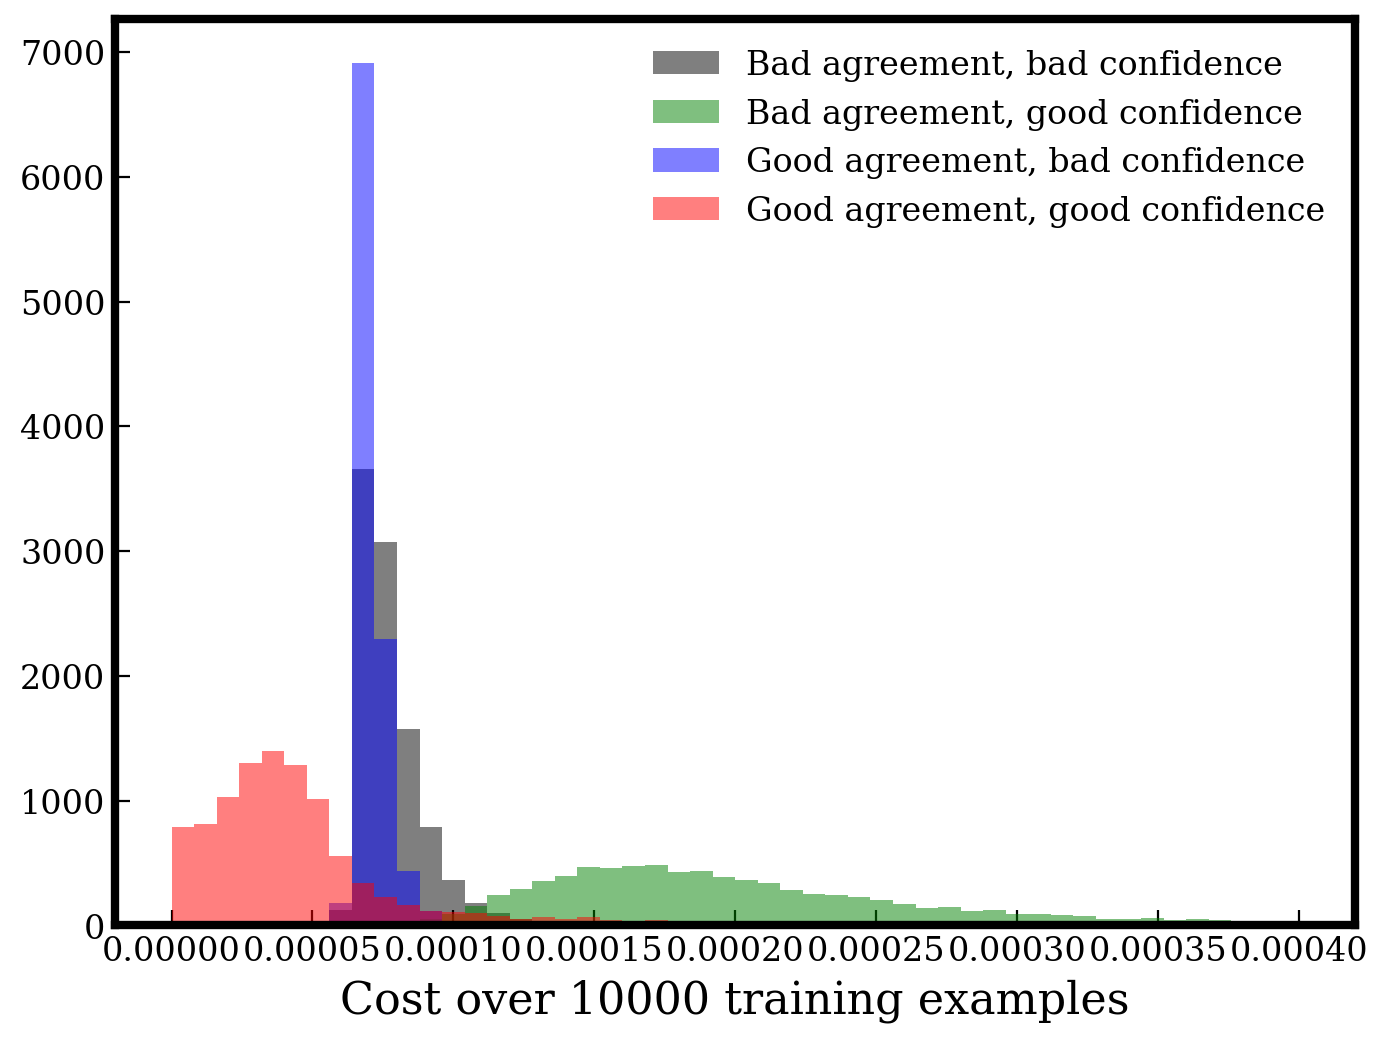

In [206]:
nTraining = 10000
# Bad agreement, bad confidence
q0_bb = np.concatenate((np.random.normal(loc=0.6,scale=0.1,size=int(nTraining/2)), np.random.normal(loc=0.4,scale=0.1,size=int(nTraining/2))))
p0_bb = np.concatenate((np.random.normal(loc=0.4,scale=0.1,size=int(nTraining/2)), np.random.normal(loc=0.6,scale=0.1,size=int(nTraining/2))))

# Good agreement, bad confidence
q0_gb = np.random.normal(loc=0.5,scale=0.1,size=nTraining)
p0_gb = np.random.normal(loc=0.5,scale=0.1,size=nTraining)

# Bad agreement, good confidence
q0_bg = np.concatenate((np.random.normal(loc=0.1,scale=0.1,size=int(nTraining/2)), np.random.normal(loc=0.9,scale=0.1,size=int(nTraining/2))))
p0_bg = np.concatenate((np.random.normal(loc=0.9,scale=0.1,size=int(nTraining/2)), np.random.normal(loc=0.1,scale=0.1,size=int(nTraining/2))))

# Good agreement, good confidence
q0_gg = np.concatenate((np.random.normal(loc=0.9,scale=0.1,size=int(nTraining/2)),np.random.normal(loc=0.1,scale=0.1,size=int(nTraining/2))))
p0_gg = np.concatenate((np.random.normal(loc=0.9,scale=0.1,size=int(nTraining/2)),np.random.normal(loc=0.1,scale=0.1,size=int(nTraining/2))))

qlist = [q0_bb, q0_gb, q0_bg, q0_gg]
plist = [p0_bb, p0_gb, p0_bg, p0_gg]

J_bb = np.zeros_like(q0_bb)
J_gb = np.zeros_like(q0_gb)
J_bg = np.zeros_like(q0_bg)
J_gg = np.zeros_like(q0_gg)
Jlist = [J_bb, J_gb, J_bg, J_gg]

for k in range(4):
    qs = qlist[k]
    ps = plist[k]
    Js = Jlist[k]
    
    qs[qs < 0.0001] = 0.0001
    qs[qs > 0.9999] = 0.9999
    
    ps[ps < 0.0001] = 0.0001
    ps[ps > 0.9999] = 0.9999
    
    
    CE = 0.
    
    for i in range(len(qs)):
        qarr = np.array((qs[i],1.-qs[i]))
        parr = np.array((ps[i],1.-ps[i]))
        
        CE = (1./nTraining)*crossEntropy(qarr,parr)
        Js[i] = CE
    
    
    #Hz calculation
    q_class0 = len(np.arange(len(qs))[qs < 0.5])/len(qs)
    if q_class0 < 0.00001:
        q_class0 = 0.00001
        
    if q_class0 > 0.99999:
        q_class0 = 0.99999
    q_class1 = 1. - q_class0
    
    Hz = -q_class0*np.log(q_class0) - q_class1*np.log(q_class1)
    
    Js = Js - Hz
    
fig = plt.figure(figsize=(8,6))
plt.hist(J_bb,color='k',bins=50,alpha=0.5,range=(0.,0.0004),label='Bad agreement, bad confidence')
plt.hist(J_bg,color='g',bins=50,alpha=0.5,range=(0.,0.0004),label='Bad agreement, good confidence')
plt.hist(J_gb,color='b',bins=50,alpha=0.5,range=(0.,0.0004),label='Good agreement, bad confidence')
plt.hist(J_gg,color='r',bins=50,alpha=0.5,range=(0.,0.0004),label='Good agreement, good confidence')
plt.legend(loc='upper right',frameon=False)
plt.xlabel("Cost over 10000 training examples",fontsize=16)
#plt.show()
plt.savefig("./costFunction_manydifferenttrainingexamples.pdf",fmt="pdf",bbox_inches="tight")

# Entropy term only, 2 classes

/Users/Emily/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


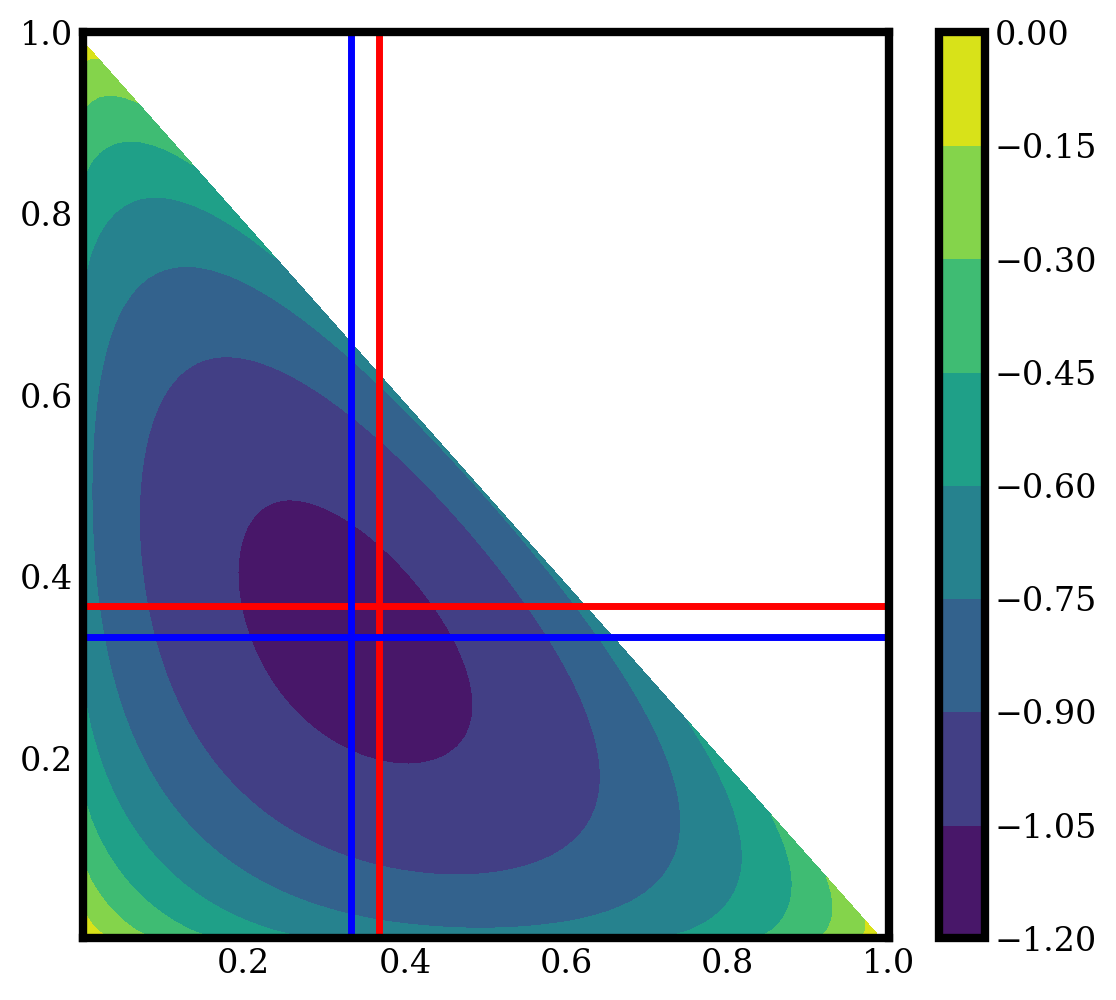

-1.087435607015455
-1.0986122886681096


In [27]:
def Hz(a,b):
    return a*np.log(a) + b*np.log(b) + (1-a-b)*np.log(1-a-b)


a = np.linspace(0.001,1.,100)
b = np.linspace(0.001,1.,100)


hzs = np.zeros((len(a),len(a)))

for i in range(len(a)):
    for j in range(len(b)):
        hzs[i,j] = Hz(a[i],b[j])
        
fig = plt.figure(figsize=(6.5,6))
plt.contourf(a,b,hzs)
plt.colorbar()
plt.axhline(1./np.e,color='r')
plt.axvline(1./np.e,color='r')
plt.axhline(1./3.,color='b')
plt.axvline(1./3.,color='b')
plt.show()

print(Hz(1./np.e,1./np.e))
print(Hz(1./3.,1./3.))